In [24]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'premier-league-player-stats-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F801841%2F1374924%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T173954Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5fbda07f30a60d2d031c246c40e287af0802d7dcc0461e42c57852ec0cac79b84db03fe0593f54fd5161eb244902c5c80728cf2cf72c2f78d8c3f040d1be904cb4f4d1057cfe685951800a2dd0440e51da0a404438285bcaa822cb18ffd61da88cfc950963578ea0b85e0638c6929a0843ac5a3c46a959e385221e235fa3268883c8c03ce8b056a1e644da11363096540ad89663f0464d60b0c13510b0d5a94f4595c02a866b0925069c36bfe508b2b77902b2f098e3da39ffb1f87f22eb52e639804e9e9cc41ee82e11113f2ed524a0864cc56f06a1a0c818bb51ec26eb795e5120c73a200ae695e3ea28be2339a47b15695a2c9fed46c95fd58b028669876e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11638 bytes downloaded
Downloaded and uncompressed: premier-league-player-stats-data
Data source import complete.


# Premier League Data Analysis and Visualization

### Importing the Basic Libraries

In [25]:
# basic operations
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-pastel')

# file path
import os
print(os.listdir("../input/premier-league-player-stats-data/"))

['Premier League Player Stats.csv']


<ipython-input-25-b8c2eb76ed67>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


## Reading the Data

In [26]:
# reading the data and checking the run time

%time data = pd.read_csv('/kaggle/input/premier-league-player-stats-data/Premier League Player Stats.csv')

print(data.shape)

CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 4.31 ms
(540, 10)


In [27]:
# checking the first 5 rows and columns
data.head()

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG
0,1,Jamie Vardy,Leicester City,35,34,3034,23,5,71,43
1,2,Danny Ings,Southampton,38,32,2812,22,2,66,38
2,3,Pierre-Emerick Aubameyang,Arsenal,36,35,3138,22,3,70,42
3,4,Raheem Shaquille Sterling,Manchester City,33,30,2660,20,1,68,38
4,5,Mohamed Salah Ghaly,Liverpool,34,33,2884,19,10,95,59


In [28]:
# decsribing the data

data.describe()

,Rank,GP,GS,MIN,G,ASST,SHOTS,SOG
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,270.500000,18.985185,15.090741,1353.657407,1.825926,1.275926,12.331481,5.909259
std,156.028843,12.847896,12.437641,1091.594162,3.551277,2.129346,16.651935,9.253446
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,135.750000,7.000000,2.000000,241.500000,0.000000,0.000000,0.000000,0.000000
50%,270.500000,20.000000,13.500000,1219.500000,0.000000,0.000000,6.000000,2.000000
75%,405.250000,30.000000,26.000000,2295.500000,2.000000,2.000000,17.000000,7.000000
max,540.000000,38.000000,38.000000,3420.000000,23.000000,20.000000,95.000000,59.000000


In [29]:
# checking NULL value

data.isnull().sum()

,0
Rank,0
PLAYER,0
TEAM,0
GP,0
GS,0
MIN,0
G,0
ASST,0
SHOTS,0
SOG,0


## New Features

\# Percentage of shots goes to goal post

Shots Accuracy % = (Total Shots(Shots)/Shots on Goal(SOG)) * 100

\# percentage of goal accuracy

Goal Accuracy % = (Goals(G)/(Shots on goal(SOG)) * 100

\# time required to shot one goal

min_per_goal = (Min(MIN)/Goals(G)) * 100

In [30]:
data.loc[data['G'] > 0, 'SA%'] =  round(data['SOG']/data['SHOTS'],3)*100
data.loc[data['G'] > 0, 'GA%'] =  round(data['G']/data['SHOTS'],3)*100
data.loc[data['G'] > 0, 'MPG'] = round(data['MIN']/data['G'],1)

In [31]:
data.head()

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
0,1,Jamie Vardy,Leicester City,35,34,3034,23,5,71,43,60.6,32.4,131.9
1,2,Danny Ings,Southampton,38,32,2812,22,2,66,38,57.6,33.3,127.8
2,3,Pierre-Emerick Aubameyang,Arsenal,36,35,3138,22,3,70,42,60.0,31.4,142.6
3,4,Raheem Shaquille Sterling,Manchester City,33,30,2660,20,1,68,38,55.9,29.4,133.0
4,5,Mohamed Salah Ghaly,Liverpool,34,33,2884,19,10,95,59,62.1,20.0,151.8


In [32]:
# check for NaN values
data.isna().sum()

,0
Rank,0
PLAYER,0
TEAM,0
GP,0
GS,0
MIN,0
G,0
ASST,0
SHOTS,0
SOG,0


In [33]:
# fill NaN values with lowest accuracy (0) for SA% and GA% beca
data['SA%'] = data['SA%'].fillna(0)
data['GA%'] = data['GA%'].fillna(0)

# fill all NaN with max time for MPG
data['MPG'] = data['MPG'].fillna(data['MPG'].max())

In [34]:
# check whether nan value is filled or not
data.isna().sum()

,0
Rank,0
PLAYER,0
TEAM,0
GP,0
GS,0
MIN,0
G,0
ASST,0
SHOTS,0
SOG,0


In [35]:
# top 10 player with highest shot accuracy
data.sort_values(by=['SA%'], ascending=False).head(10)

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
239,240,DeAndre Yedlin,Newcastle United,16,10,936,1,0,1,1,100.0,100.0,936.0
108,109,Jeffrey Schlupp,Crystal Palace,17,11,1034,3,1,12,10,83.3,25.0,344.7
148,149,Ciaran Clark,Newcastle United,14,14,1188,2,0,5,4,80.0,40.0,594.0
165,166,Florian Lejeune,Newcastle United,6,4,441,2,0,4,3,75.0,50.0,220.5
24,25,Troy Deeney,Watford,27,26,2234,10,2,32,23,71.9,31.2,223.4
88,89,Bernard Anício Caldeira Duarte,Everton,27,15,1278,3,2,7,5,71.4,42.9,426.0
94,95,Michael Obafemi,Southampton,21,8,661,3,2,7,5,71.4,42.9,220.3
190,191,Cédric Ricardo Alves Soares,Arsenal,21,19,1559,1,1,7,5,71.4,14.3,1559.0
221,222,Pedro Rodríguez Ledesma,Chelsea,11,8,662,1,1,14,10,71.4,7.1,662.0
114,115,Naby Deco Keïta,Liverpool,18,9,814,2,3,10,7,70.0,20.0,407.0


In [36]:
# top 10 player with highest shot accuracy
data.sort_values(by=['GA%'], ascending=False).head(10)

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
239,240,DeAndre Yedlin,Newcastle United,16,10,936,1,0,1,1,100.0,100.0,936.0
163,164,Matthew Longstaff,Newcastle United,9,6,572,2,0,3,2,66.7,66.7,286.0
78,79,Jorge Luiz Frello Filho,Chelsea,31,27,2384,4,2,8,4,50.0,50.0,596.0
174,175,Xherdan Shaqiri,Liverpool,7,2,182,1,0,2,1,50.0,50.0,182.0
113,114,Steven Bergwijn,Tottenham Hotspur,14,8,702,3,1,6,4,66.7,50.0,234.0
165,166,Florian Lejeune,Newcastle United,6,4,441,2,0,4,3,75.0,50.0,220.5
88,89,Bernard Anício Caldeira Duarte,Everton,27,15,1278,3,2,7,5,71.4,42.9,426.0
94,95,Michael Obafemi,Southampton,21,8,661,3,2,7,5,71.4,42.9,220.3
64,65,Divock Okoth Origi,Liverpool,28,7,706,4,1,10,6,60.0,40.0,176.5
148,149,Ciaran Clark,Newcastle United,14,14,1188,2,0,5,4,80.0,40.0,594.0


In [37]:
# top 10 player with highest shot accuracy
data.sort_values(by=['MPG'], ascending=True).head(10)

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
10,11,Sergio Leonel Agüero del Castillo,Manchester City,24,18,1456,16,3,54,28,51.9,29.6,91.0
244,245,Curtis Jones,Liverpool,6,1,122,1,0,5,2,40.0,20.0,122.0
32,33,Olivier Giroud,Chelsea,18,12,999,8,0,35,19,54.3,22.9,124.9
1,2,Danny Ings,Southampton,38,32,2812,22,2,66,38,57.6,33.3,127.8
23,24,Mason Greenwood,Manchester United,31,12,1312,10,1,32,20,62.5,31.2,131.2
0,1,Jamie Vardy,Leicester City,35,34,3034,23,5,71,43,60.6,32.4,131.9
3,4,Raheem Shaquille Sterling,Manchester City,33,30,2660,20,1,68,38,55.9,29.4,133.0
2,3,Pierre-Emerick Aubameyang,Arsenal,36,35,3138,22,3,70,42,60.0,31.4,142.6
6,7,Harry Kane,Tottenham Hotspur,29,29,2589,18,2,62,37,59.7,29.0,143.8
12,13,Gabriel Fernando de Jesus,Manchester City,34,21,2027,14,7,81,48,59.3,17.3,144.8


## Analyzing Club Data

In [38]:
def team(x):
    return data[data['TEAM'] == x]

## Analysing Arsenal club data

In [39]:
arsenal = team('Arsenal')

In [40]:
# top 10 arsenal player with highest shot accuracy
arsenal.sort_values(by=['MPG'], ascending=True).head(10)

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
2,3,Pierre-Emerick Aubameyang,Arsenal,36,35,3138,22,3,70,42,60.0,31.4,142.6
22,23,Alexandre Lacazette,Arsenal,30,22,1877,10,4,44,26,59.1,22.7,187.7
99,100,Gabriel Teodoro Martinelli Silva,Arsenal,14,6,655,3,0,10,5,50.0,30.0,218.3
166,167,Eddie Nketiah,Arsenal,13,7,633,2,0,13,5,38.5,15.4,316.5
59,60,Nicolas Pépé,Arsenal,31,22,2015,5,6,37,18,48.6,13.5,403.0
202,203,Reiss Nelson,Arsenal,17,7,627,1,0,6,4,66.7,16.7,627.0
206,207,Joseph Willock,Arsenal,29,8,844,1,1,12,5,41.7,8.3,844.0
144,145,Sokratis Papastathopoulos,Arsenal,19,19,1697,2,0,5,2,40.0,40.0,848.5
241,242,Kieran Tierney,Arsenal,15,12,992,1,1,5,2,40.0,20.0,992.0
204,205,Calum Chambers,Arsenal,14,13,1103,1,1,8,2,25.0,12.5,1103.0


In [41]:
# top 10 arsenal player with highest goal accuracy
arsenal.sort_values(by=['GA%'], ascending=False).head(10)

,Rank,PLAYER,TEAM,GP,GS,MIN,G,ASST,SHOTS,SOG,SA%,GA%,MPG
144,145,Sokratis Papastathopoulos,Arsenal,19,19,1697,2,0,5,2,40.0,40.0,848.5
2,3,Pierre-Emerick Aubameyang,Arsenal,36,35,3138,22,3,70,42,60.0,31.4,142.6
99,100,Gabriel Teodoro Martinelli Silva,Arsenal,14,6,655,3,0,10,5,50.0,30.0,218.3
22,23,Alexandre Lacazette,Arsenal,30,22,1877,10,4,44,26,59.1,22.7,187.7
233,234,Mesut Özil,Arsenal,18,18,1448,1,2,5,3,60.0,20.0,1448.0
241,242,Kieran Tierney,Arsenal,15,12,992,1,1,5,2,40.0,20.0,992.0
242,243,Héctor Bellerín,Arsenal,15,13,1159,1,0,5,2,40.0,20.0,1159.0
202,203,Reiss Nelson,Arsenal,17,7,627,1,0,6,4,66.7,16.7,627.0
166,167,Eddie Nketiah,Arsenal,13,7,633,2,0,13,5,38.5,15.4,316.5
190,191,Cédric Ricardo Alves Soares,Arsenal,21,19,1559,1,1,7,5,71.4,14.3,1559.0


## Data Visualization

<ipython-input-42-111ae9503bab>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = 50, kde = False, color = 'b')


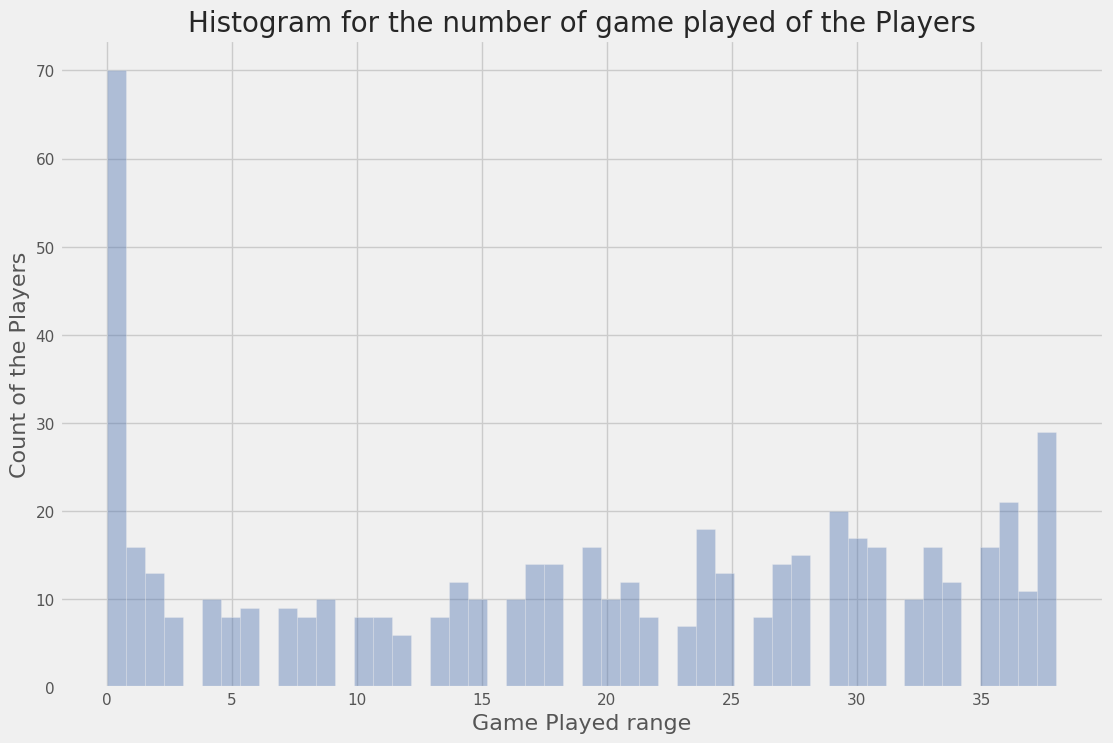

In [42]:
x = data.GP
plt.figure(figsize = (12, 8))

ax = sns.distplot(x, bins = 50, kde = False, color = 'b')
ax.set_xlabel(xlabel = 'Game Played range', fontsize = 16)
ax.set_ylabel(ylabel = 'Count of the Players',fontsize = 16)
ax.set_title(label = 'Histogram for the number of game played of the Players', fontsize = 20)
plt.show()


<ipython-input-43-c5c7ddeb91d1>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = 50, kde = False, color = 'r')


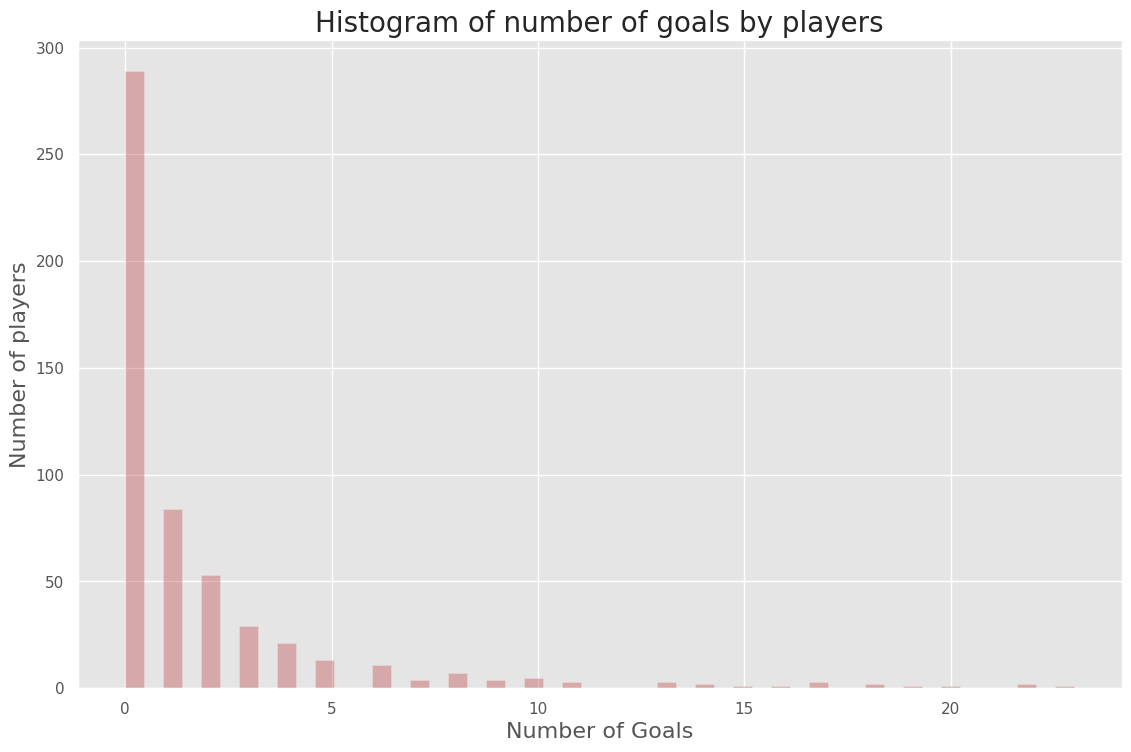

In [43]:
# To show Different overall scores of the players participating in the FIFA 2019

sns.set(style = "dark", palette = "deep", color_codes = True)
x = data.G
plt.figure(figsize = (12,8))
plt.style.use('ggplot')

ax = sns.distplot(x, bins = 50, kde = False, color = 'r')
ax.set_xlabel(xlabel = "Number of Goals", fontsize = 16)
ax.set_ylabel(ylabel = 'Number of players', fontsize = 16)
ax.set_title(label = 'Histogram of number of goals by players', fontsize = 20)
plt.show()

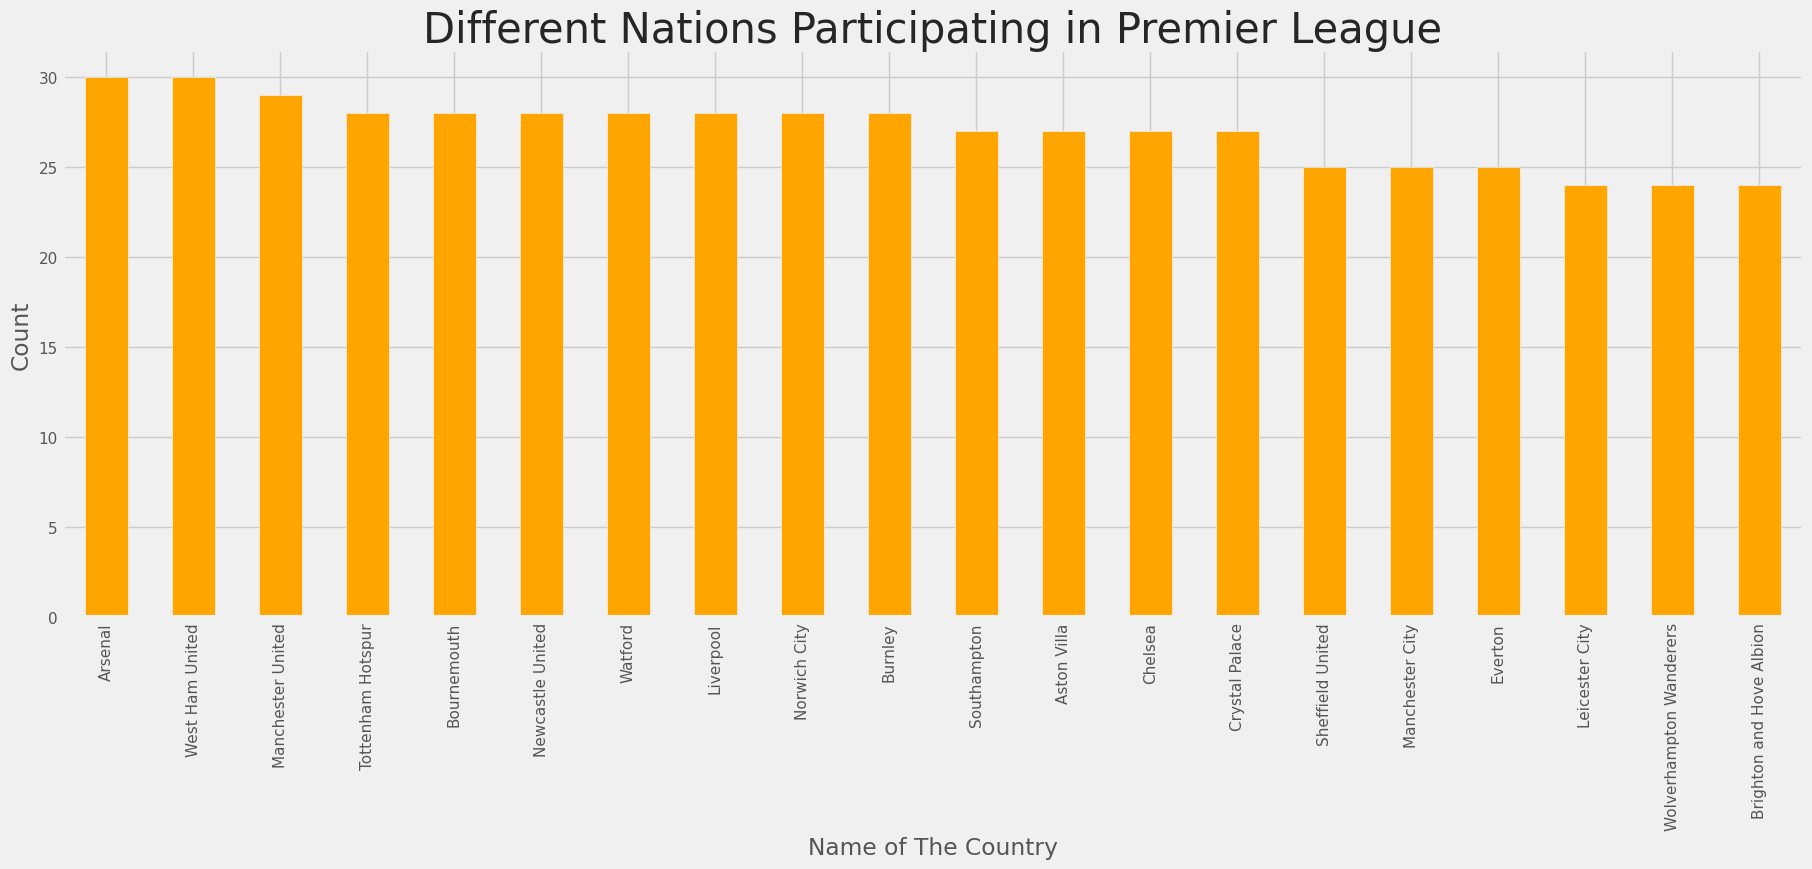

In [44]:
# To show Different nations participating in the premier league

plt.style.use('fivethirtyeight')
data['TEAM'].value_counts().plot.bar(color = 'orange', figsize = (20, 7))
plt.title('Different Nations Participating in Premier League', fontsize = 30, fontweight = 20)
plt.xlabel('Name of The Country')
plt.ylabel('Count')
plt.show()

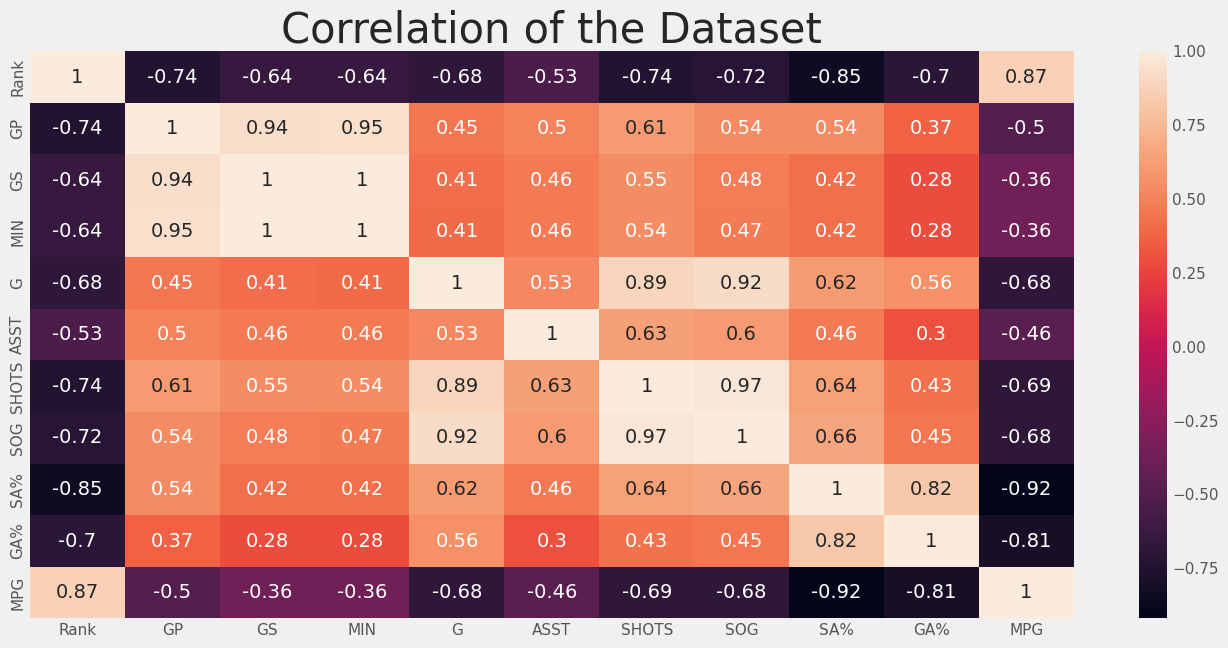

In [56]:
# plotting a correlation heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features for correlation analysis
numerical_data = data.select_dtypes(include=['number'])

sns.heatmap(numerical_data.corr(), annot = True)

plt.title('Correlation of the Dataset', fontsize = 30)
plt.show()

In [57]:
# picking up the countries with highest number of players to compare their overall scores

data['TEAM'].value_counts()

,count
TEAM,
Arsenal,30
West Ham United,30
Manchester United,29
Tottenham Hotspur,28
Bournemouth,28
Newcastle United,28
Watford,28
Liverpool,28
Norwich City,28


<ipython-input-58-2334eb1f200e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x = data_teams['TEAM'], y = data_teams['G'], palette = 'Reds')


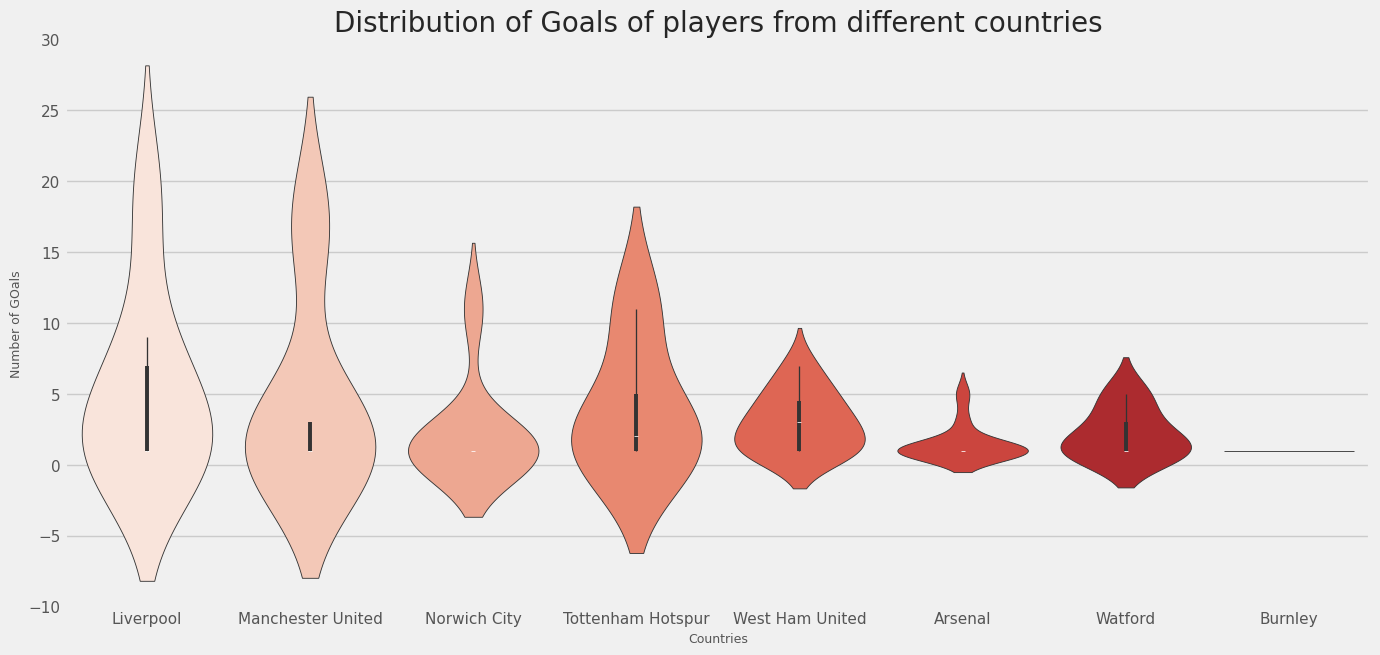

In [58]:
# Every Nations' Player and their goals

teams = ('West Ham United', 'Arsenal', 'Manchester United', 'Burnley', 'Norwich City', 'Liverpool', 'Watford', 'Tottenham Hotspur')
data_teams = data.loc[data['TEAM'].isin(teams) & data['G']]

plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.violinplot(x = data_teams['TEAM'], y = data_teams['G'], palette = 'Reds')
ax.set_xlabel(xlabel = 'Countries', fontsize = 9)
ax.set_ylabel(ylabel = 'Number of GOals', fontsize = 9)
ax.set_title(label = 'Distribution of Goals of players from different countries', fontsize = 20)
plt.show()

<ipython-input-49-2985176a588a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = data_teams['TEAM'], y = data_teams['SHOTS'], palette = 'spring')


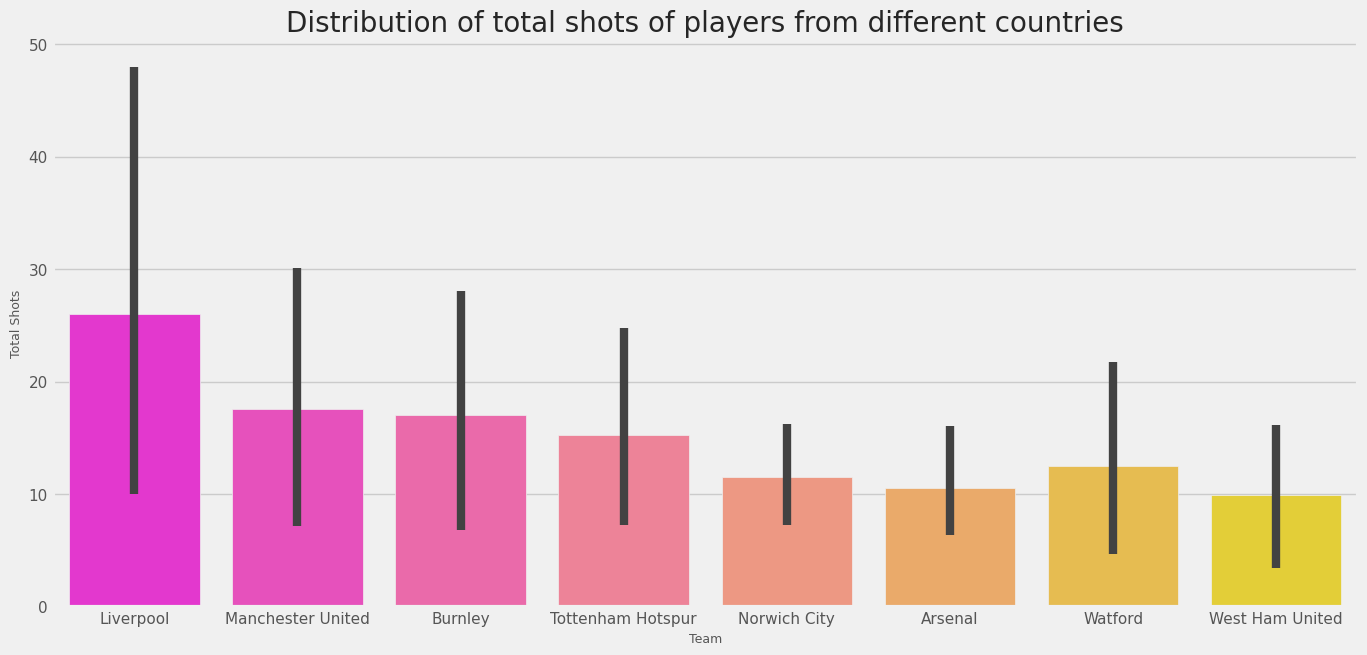

In [49]:
# Every Nations' Player and their overall scores

teams = ('West Ham United', 'Arsenal', 'Manchester United', 'Burnley', 'Norwich City', 'Liverpool', 'Watford', 'Tottenham Hotspur')
data_teams = data.loc[data['TEAM'].isin(teams) & data['SHOTS']]

plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.barplot(x = data_teams['TEAM'], y = data_teams['SHOTS'], palette = 'spring')
ax.set_xlabel(xlabel = 'Team', fontsize = 9)
ax.set_ylabel(ylabel = 'Total Shots', fontsize = 9)
ax.set_title(label = 'Distribution of total shots of players from different countries', fontsize = 20)
plt.show()

In [50]:
# finding 20 top Players who have max number of goals

highest_goals = data.sort_values('G', ascending = False)[['PLAYER','TEAM','GP','GS','G']].head(20)
print(highest_goals)

                               PLAYER                     TEAM  GP  GS   G
0                         Jamie Vardy           Leicester City  35  34  23
1                          Danny Ings              Southampton  38  32  22
2           Pierre-Emerick Aubameyang                  Arsenal  36  35  22
3           Raheem Shaquille Sterling          Manchester City  33  30  20
4                 Mohamed Salah Ghaly                Liverpool  34  33  19
5                          Sadio Mané                Liverpool  35  31  18
6                          Harry Kane        Tottenham Hotspur  29  29  18
7       Raúl Alonso Jiménez Rodríguez  Wolverhampton Wanderers  38  37  17
8                     Marcus Rashford        Manchester United  31  31  17
9                     Anthony Martial        Manchester United  32  31  17
10  Sergio Leonel Agüero del Castillo          Manchester City  24  18  16
11               Tammy Bakumo-Abraham                  Chelsea  34  25  15
12          Gabriel Ferna

In [51]:
# finding 20 top Players who have lowest number of goals

lowest_goals = data.sort_values('G', ascending = True)[['PLAYER','TEAM','GP','GS','G']].head(20)
print(lowest_goals)

                    PLAYER                      TEAM  GP  GS  G
532            Alfie Lewis           West Ham United   0   0  0
533       Leonardo Campana   Wolverhampton Wanderers   0   0  0
534            Josh Benson                   Burnley   0   0  0
535          Dennis Cirkin         Tottenham Hotspur   0   0  0
536        Darnell Johnson            Leicester City   0   0  0
537    Timothy Fosu-Mensah         Manchester United   3   2  0
538         Conor Coventry           West Ham United   0   0  0
539          Alex Cochrane  Brighton and Hove Albion   0   0  0
524             Matt Macey                   Arsenal   0   0  0
525          Matthew Smith                   Arsenal   0   0  0
526            Tommy Doyle           Manchester City   1   0  0
527  Taylor Harwood-Bellis           Manchester City   0   0  0
528            Cole Palmer           Manchester City   0   0  0
529    Adalberto Peñaranda                   Watford   0   0  0
530    Alexandre Jankewitz              

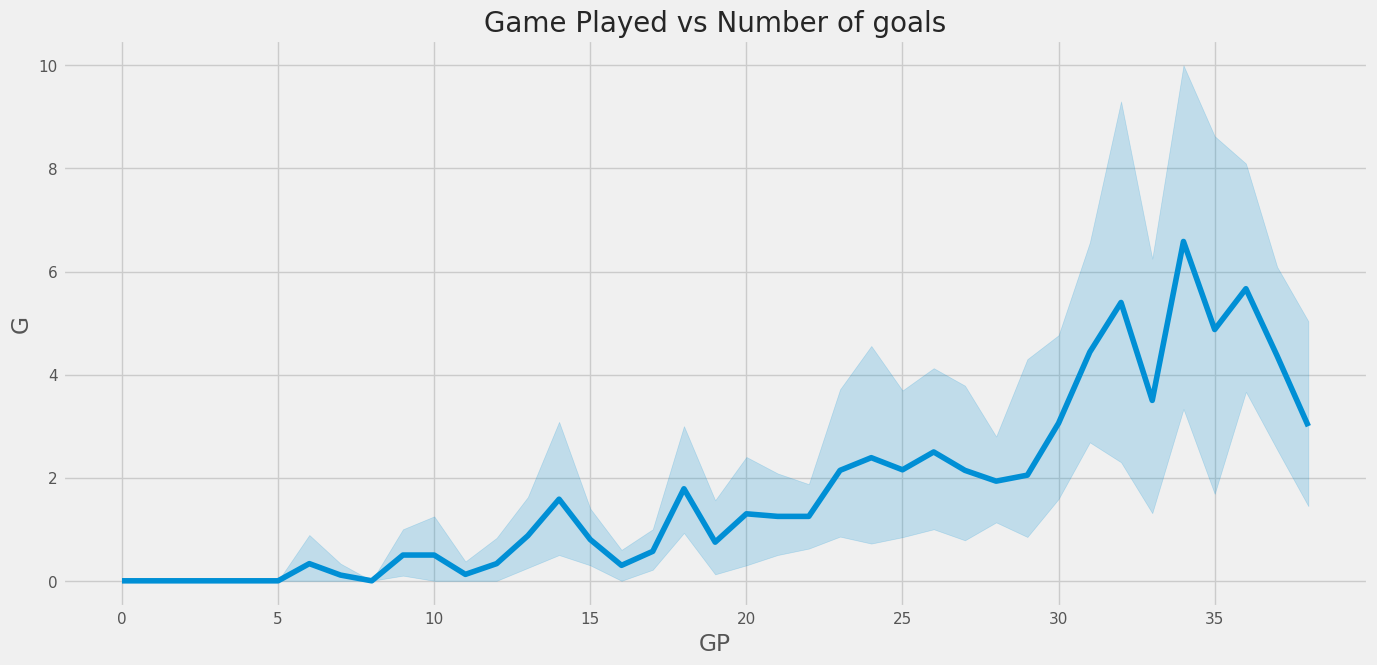

In [60]:
sns.lineplot(x='GP', y='G', data=data)
plt.title('Game Played vs Number of goals', fontsize = 20)

plt.show()

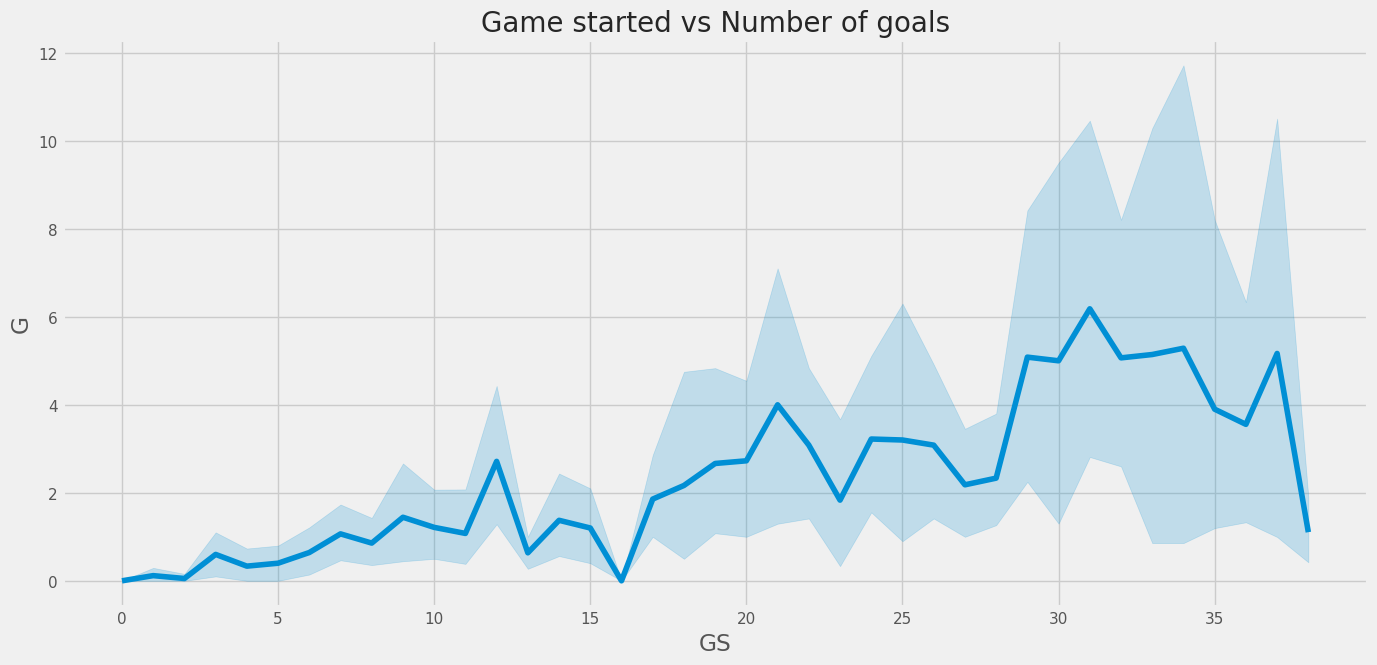

In [61]:
sns.lineplot(x='GS', y='G', data=data) # Pass the x and y values with column names as string and data as a dataframe to the function.
plt.title('Game started vs Number of goals', fontsize = 20)

plt.show()

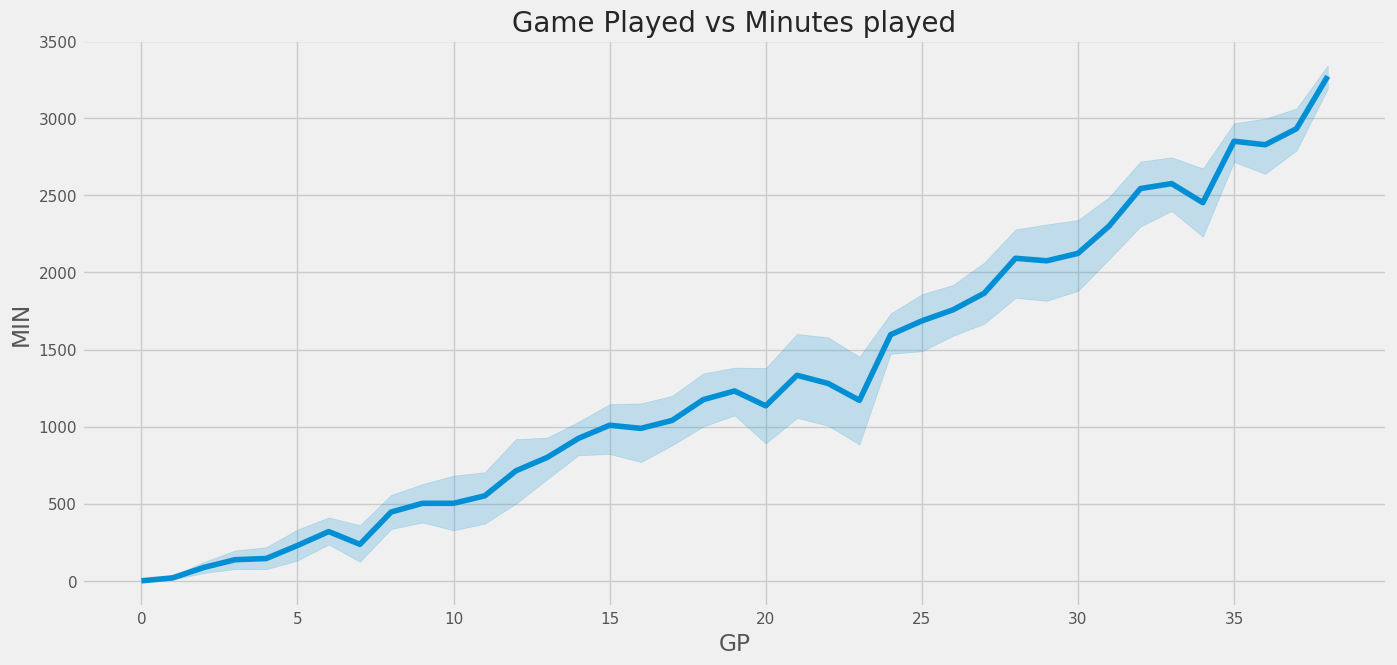

In [63]:
sns.lineplot(x=data['GP'], y=data['MIN']) # Pass the x and y values as keyword arguments.
plt.title('Game Played vs Minutes played', fontsize = 20)

plt.show()

In [64]:
# total goals by each team
goals = data.groupby("TEAM")["G"].sum().reset_index().sort_values(by = "G",ascending = False)

<ipython-input-66-766da2cb2f41>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="G",y="TEAM",


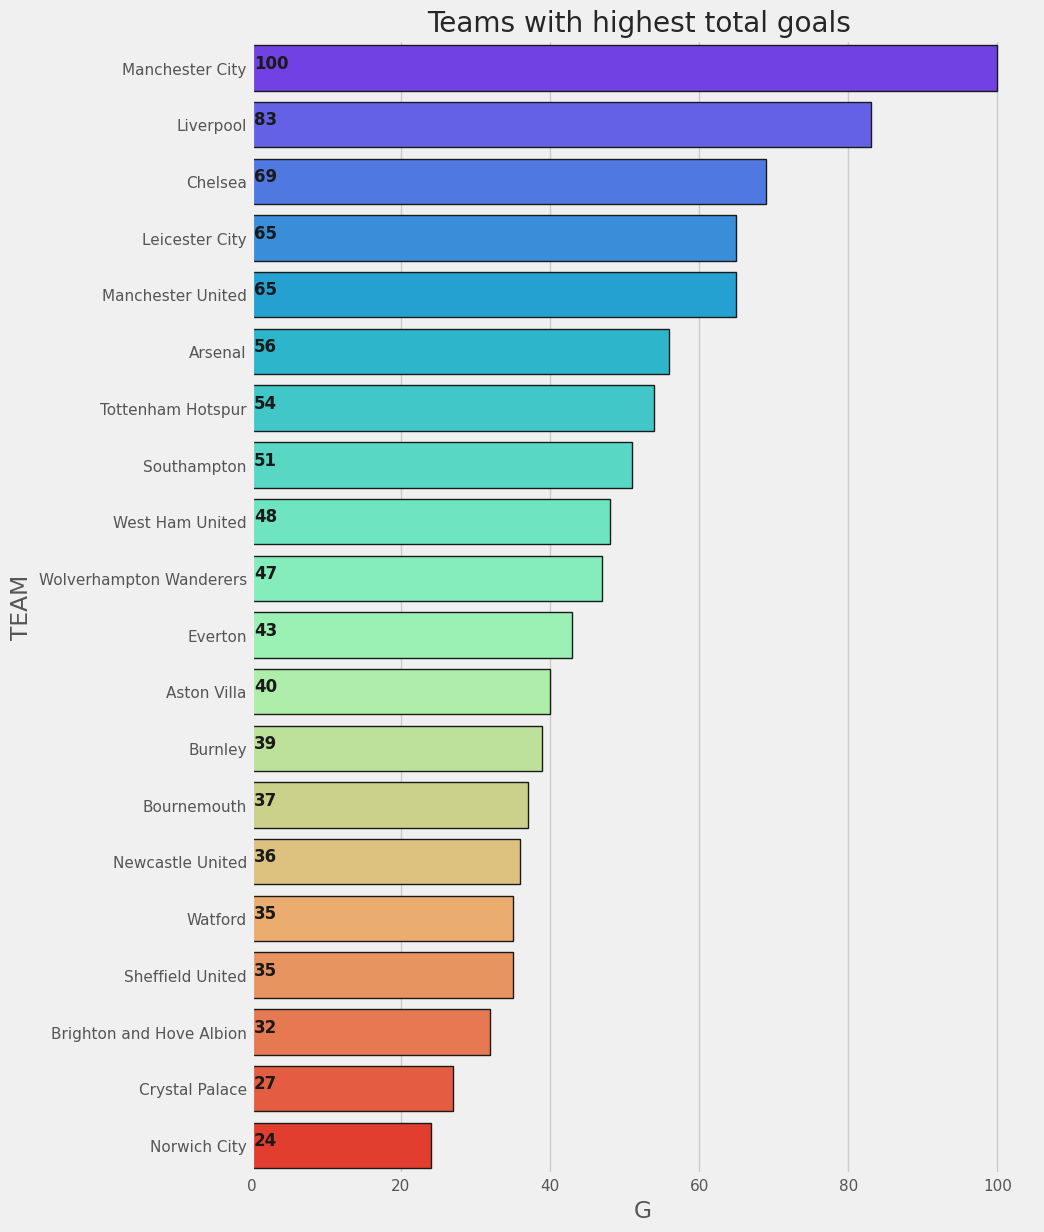

In [66]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x="G",y="TEAM",
                 data=goals,palette="rainbow",
                 linewidth = 1,edgecolor = "k") # Changed edgecolor to "k"
for i,j in enumerate(goals["G"][:20]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)
plt.title("Teams with highest total goals ")
plt.show()